In [1]:
from dask.distributed import Client

client = Client()
client.restart()  # Restart Dask cluster, clearing all tasks and memory

2024-08-11 15:02:54,293 - distributed.nanny - WARNING - Restarting worker
2024-08-11 15:02:54,296 - distributed.nanny - WARNING - Restarting worker


In [2]:
client.shutdown()

In [3]:
import gc
gc.collect()

291

In [4]:
import os
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import folium

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.temporal import xr_phenology, temporal_statistics
from dea_tools.datahandling import load_ard
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [5]:
# Step 1: Initialize Dask and Datacube
client = create_local_dask_cluster(return_client=True)
dc = datacube.Datacube(app='Vegetation_phenology')

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jmackenzie@earthwatch.org.au/proxy/8787/status,
Dashboard: /user/jmackenzie@earthwatch.org.au/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46833,Workers: 1
Dashboard: /user/jmackenzie@earthwatch.org.au/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:34699,Total threads: 2
Dashboard: /user/jmackenzie@earthwatch.org.au/proxy/37069/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:45457,


2024-08-11 15:03:38,749 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'dataset-f9dfb50d1901434c9ad5755094ad47a7' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x7f630dcd89d0>, (Dataset <id=f9dfb50d-1901-434c-9ad5-755094ad47a7 product=ga_s2am_ard_3 location=s3://dea-public-data/baseline/ga_s2am_ard_3/55/KDU/2021/10/20/20211020T031721/ga_s2am_ard_3-2-1_55KDU_2021-10-20_final.odc-metadata.yaml>,), {})
new run_spec: (<function execute_task at 0x7f630dcd89d0>, (Dataset <id=f9dfb50d-1901-434c-9ad5-755094ad47a7 product=ga_s2am_ard_3 location=s3://dea-public-data/baseline/ga_

In [6]:
# Step 2: Define Centroid and Display Map
lat_centroid = -19.172048
lon_centroid = 146.824996

m = folium.Map(location=[lat_centroid, lon_centroid], zoom_start=15)
folium.Marker(
    location=[lat_centroid, lon_centroid],
    popup=f"Centroid: ({lat_centroid}, {lon_centroid})",
    icon=folium.Icon(color='red', icon='info-sign')
).add_to(m)
m

In [7]:
# Step 3: Define Query and Load Data
time_range = ('2015-08-10', '2024-08-10')
veg_proxy = 'NDVI'

query = {
    'x': lon_centroid,
    'y': lat_centroid,
    'time': time_range,
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_nir_1'],
    'resolution': (-20, 20),
    'output_crs': 'epsg:6933',
    'group_by':'solar_day'
}

# Load available data from Sentinel-2
ds = load_ard(
    dc=dc,
    products=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
    cloud_mask='s2cloudless',
    min_gooddata=0.99,
    **query,
)

Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Counting good quality pixels for each time step using s2cloudless


/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Filtering to 307 out of 559 time steps with at least 99.0% good quality pixels
Applying s2cloudless pixel quality/cloud mask
Loading 307 time steps


In [8]:
# Step 4: Shut Down Dask Client to Avoid Issues
client.close()


In [9]:
# Step 5: Perform NDVI Calculations
ds = calculate_indices(ds, index=veg_proxy, collection='ga_s2_3')
ndvi_timeseries = ds[veg_proxy].sel(x=lon_centroid, y=lat_centroid, method="nearest")

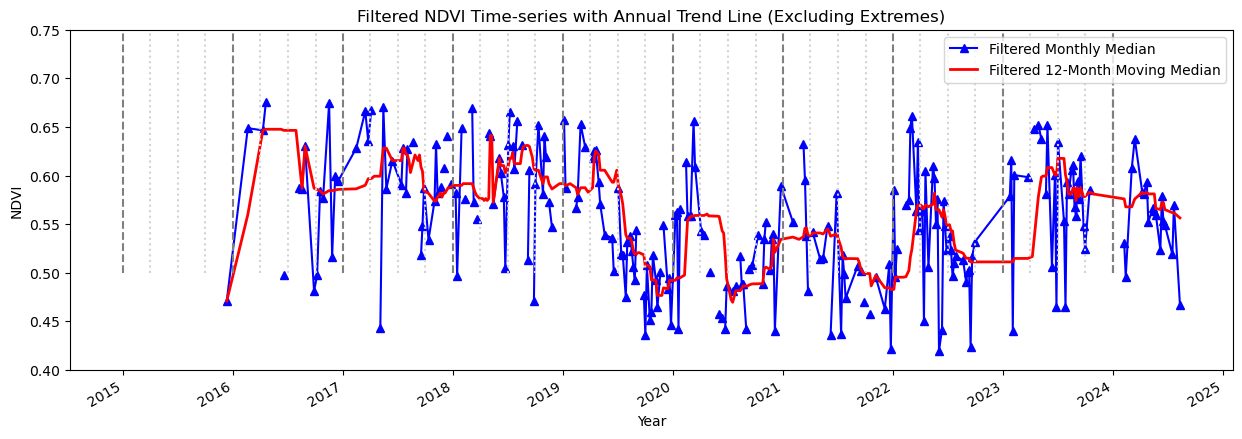

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Set a threshold to exclude extreme values (adjust as needed)
threshold_percentile_low = 10
threshold_percentile_high = 90

# Calculate percentiles for filtering extreme values
percentile_low = ds[veg_proxy].quantile(q=threshold_percentile_low / 100, dim='time')
percentile_high = ds[veg_proxy].quantile(q=threshold_percentile_high / 100, dim='time')

# Filter out extreme values for monthly median
filtered_monthly = ds[veg_proxy].where(
    (ds[veg_proxy] >= percentile_low) & (ds[veg_proxy] <= percentile_high)
)

# Take the monthly median over 'x' and 'y' to reduce to 1D array
filtered_monthly_median = filtered_monthly.median(['x', 'y'])

# Plot the monthly median values along with the annual trend line
fig, ax = plt.subplots(figsize=(15, 5))

# Plotting the filtered monthly median
filtered_monthly_median.plot.line('b-^', ax=ax, label='Filtered Monthly Median')

# Calculate the 12-month moving median for the annual trend line
filtered_annual_trend = filtered_monthly_median.rolling(time=12, min_periods=1).median()
filtered_annual_trend.plot.line('r-', linewidth=2, ax=ax, label='Filtered 12-Month Moving Median')

# Set Y-axis limits explicitly
ax.set_ylim(0.4, 0.75)

# Draw vertical lines for each year
for year in range(2015, 2025):
    ax.vlines(np.datetime64(str(year) + '-01-01'), ymin=0.5, ymax=0.75, color='gray', linestyle='--')

# Set title, ylabel, and legend
ax.set_title(f'Filtered {veg_proxy} Time-series with Annual Trend Line (Excluding Extremes)')
ax.set_ylabel(veg_proxy)
ax.legend()

# Set x-axis label to 'Year'
ax.set_xlabel('Year')

# Add month intervals to the x-axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Customize the appearance of the minor (month) ticks
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.tick_params(axis='x', which='minor', size=0)  # Set size to 0 to hide minor tick marks

# Draw dashed line for the year 2024 major tick
ax.vlines(np.datetime64('2024-01-01'), ymin=0.5, ymax=0.75, color='gray', linestyle='--')

# Draw lighter grey dotted lines between major labels on months 5, 7, and 10
months_to_draw_dotted_lines = [4, 7, 10]
for year in range(2015, 2024):
    for month in months_to_draw_dotted_lines:
        ax.vlines(np.datetime64(f'{year}-{month:02d}-01'), ymin=0.5, ymax=0.75, color='lightgrey', linestyle=':')

# Autoformat the x-axis labels
fig.autofmt_xdate()

# Show the final plot
plt.show()



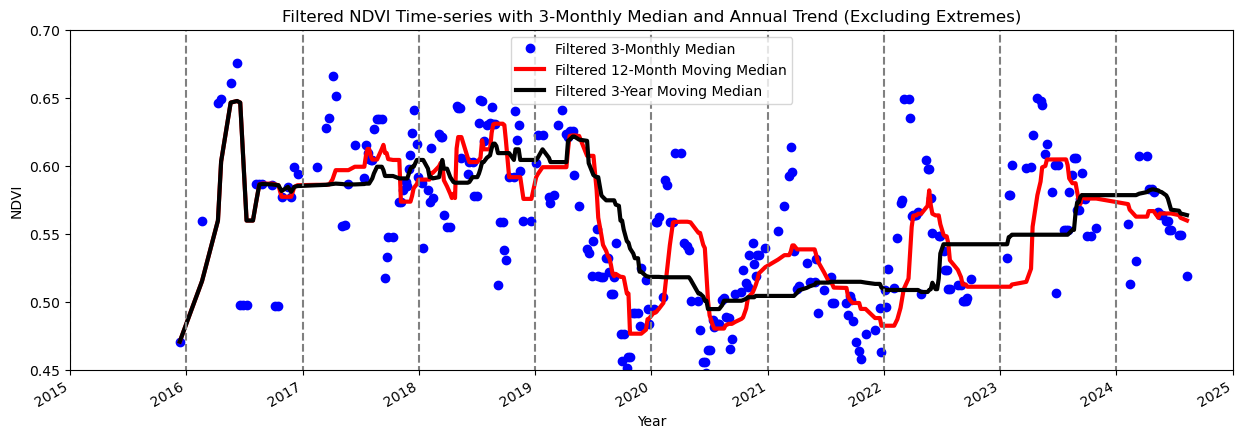

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Set a threshold to exclude extreme values (adjust as needed)
threshold_percentile_low = 10
threshold_percentile_high = 90

# Calculate percentiles for filtering extreme values
percentile_low = ds[veg_proxy].quantile(q=threshold_percentile_low / 100, dim='time')
percentile_high = ds[veg_proxy].quantile(q=threshold_percentile_high / 100, dim='time')

# Filter out extreme values for 3-monthly median
filtered = ds[veg_proxy].where(
    (ds[veg_proxy] >= percentile_low) & (ds[veg_proxy] <= percentile_high)
)

# Take the 3-monthly rolling median over 'x' and 'y' to reduce to 1D array
filtered_3monthly_median = filtered.median(['x', 'y']).rolling(time=3, min_periods=1).median()

# Plot the 3-monthly median values as points
fig, ax = plt.subplots(figsize=(15, 5))

# Plotting the filtered 3-monthly median as points
ax.plot(filtered_3monthly_median['time'], filtered_3monthly_median, 'bo', label='Filtered 3-Monthly Median')

# Calculate the 12-month moving median for the annual trend line
filtered_annual_trend = filtered_3monthly_median.rolling(time=12, min_periods=1).median()
ax.plot(filtered_annual_trend['time'], filtered_annual_trend, 'r-', linewidth=3, label='Filtered 12-Month Moving Median')

# Calculate the 3-year rolling median
filtered_3yr_trend = filtered_3monthly_median.rolling(time=36, min_periods=1).median()  # 36 months = 3 years
ax.plot(filtered_3yr_trend['time'], filtered_3yr_trend, 'k-', linewidth=3, label='Filtered 3-Year Moving Median')

# Set Y-axis limits explicitly
ax.set_ylim(0.45, 0.7)  # Adjust Y-axis limits as needed

# Set X-axis limits to start at 1988 and end at 2025
ax.set_xlim(np.datetime64('2015-01-01'), np.datetime64('2025-01-01'))

# Draw vertical lines for each year
for year in range(2015, 2024):
    ax.vlines(np.datetime64(str(year) + '-01-01'), ymin=0.0, ymax=1.0, color='gray', linestyle='--')

# Set title, ylabel, and legend
ax.set_title(f'Filtered {veg_proxy} Time-series with 3-Monthly Median and Annual Trend (Excluding Extremes)')
ax.set_ylabel(veg_proxy)
ax.legend()

# Set x-axis label to 'Year'
ax.set_xlabel('Year')

# Add year intervals to the x-axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Customize the appearance of the minor (month) ticks
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.tick_params(axis='x', which='minor', size=0)  # Set size to 0 to hide minor tick marks

# Draw dashed line for the year 2024 major tick
ax.vlines(np.datetime64('2024-01-01'), ymin=0.0, ymax=1, color='gray', linestyle='--')

# Autoformat the x-axis labels
fig.autofmt_xdate()

# Save the figure as a .jpg file
plt.savefig('CockleDB1.jpg', format='jpg', dpi=300, bbox_inches='tight')

# Show the final plot
plt.show()


In [27]:
# Example cleanup after using Dask
ds = None  # Dereference the dataset to help with garbage collection
client.close()  # Close the Dask client

import gc
gc.collect()  # Force garbage collection to clean up memory

# Start a new Dask client if needed
client = create_local_dask_cluster(return_client=True)


/env/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41351 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jmackenzie@earthwatch.org.au/proxy/41351/status,
Dashboard: /user/jmackenzie@earthwatch.org.au/proxy/41351/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36065,Workers: 1
Dashboard: /user/jmackenzie@earthwatch.org.au/proxy/41351/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:36239,Total threads: 2
Dashboard: /user/jmackenzie@earthwatch.org.au/proxy/37349/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:38411,
